In [1]:
import nltk
import numpy as np
import pickle as pkl
import pandas as pd
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Dense, Lambda
from keras.utils import to_categorical, Sequence
from gensim.models import Doc2Vec
import os
import time
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize, sent_tokenize
import tensorflow_hub as hub
from tensorflow.errors import InvalidArgumentError

module_url = 'https://tfhub.dev/google/universal-sentence-encoder-large/3'
embed = hub.Module(module_url)

Using TensorFlow backend.


INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.


In [2]:
class_mapping = {}
with open('../dbpedia_csv/classes.txt') as txt_file:
    line_num = 0
    for line in txt_file:
        class_mapping[line_num] = line.strip()
        line_num+=1
        
print(class_mapping)

{0: 'Company', 1: 'EducationalInstitution', 2: 'Artist', 3: 'Athlete', 4: 'OfficeHolder', 5: 'MeanOfTransportation', 6: 'Building', 7: 'NaturalPlace', 8: 'Village', 9: 'Animal', 10: 'Plant', 11: 'Album', 12: 'Film', 13: 'WrittenWork'}


### Create Data Generator

In [ ]:
class USE_Doc2Vec_DataGenerator(Sequence):
    def __init__(self, list_IDs, batch_size = 32, n_classes=14, shuffle=True):
        self.dim = (1,)
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.list_IDs)/self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index:(index+1)]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X,y = self.__data_generation(list_IDs_temp)
        return X,y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, list_IDs_temp):
        X_USE = []
        X_Doc2Vec = np.empty((self.batch_size, 300,))
        y = np.empty((self.batch_size), dtype = int)
        for item in list_IDs_temp:
            Xarray = pkl.load(open('../Training/'+item, 'rb'))
        for i, row in enumerate(Xarray[1]):
            cur_sent = ' '.join(row)
            X_USE.append(cur_sent)
            X_Doc2Vec[i,] = Doc2Vec_model.infer_vector(sent_tokenize(cur_sent)[-1])
            y[i] = Xarray[0]-1
        X_USE = np.array(X_USE,dtype = object)[:,np.newaxis]
        
        return [X_USE, X_Doc2Vec], to_categorical(y, num_classes = self.n_classes)

In [ ]:
Doc2Vec_model = Doc2Vec.load('../Doc2Vec/Doc2Vec.model')
Doc2Vec_model.delete_temporary_training_data(keep_doctags_vectors = True, keep_inference = True)

In [ ]:
params = {'batch_size':32, 'n_classes':14,'shuffle':True}
partition, labels = pkl.load(open('../Training/Metadata', 'rb'))
for key in labels.keys():
    labels[key] -= 1
training_generator = USE_Doc2Vec_DataGenerator(partition['train'], **params)

### Create Keras layer out of TF-hub module

In [ ]:
def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)),signature='default', as_dict=True)['default']

In [ ]:
USE_input = Input(shape=(1,), dtype = tf.string, name = 'USE_input')
embedding = Lambda(UniversalEmbedding, output_shape = (512, ))(USE_input)
USE_output = Dense(256, activation='relu')(embedding)
Doc2Vec_input = Input(shape = (300,), name = 'Doc2Vec_input')
Doc2Vec_dense = Dense(128, activation = 'relu')(Doc2Vec_input)
Doc2Vec_output = Dense(128, activation = 'relu')(Doc2Vec_dense)
concat = keras.layers.concatenate([USE_output, Doc2Vec_output])
pred = Dense(14, activation = 'softmax')(concat)
model = Model(inputs = [USE_input, Doc2Vec_input], outputs = pred)
model.compile(loss= 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.name = 'USEparagraph_Doc2Vecsentence'
loss_acc_path = model.name+'loss_acc'

### Train model

In [ ]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    history = model.fit_generator(generator = training_generator, epochs = 1, verbose = 1)
    model.save_weights(model.name+'.h5')

### Evaluate model

In [ ]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    model.load_weights(model.name+'.h5')  
    accuracies = pkl.load(open('USEparagraph_Doc2Vecsentence_accuracy', 'rb'))
    start = time.time()
    for label in os.listdir('Testing'):
        if label not in accuracies.keys():
            accuracies[label] = {}
        for sent_len in os.listdir('Testing/{}'.format(label)):
            if sent_len not in accuracies[label].keys():
                X_USE = []
                X_Doc2Vec = np.empty((0,300))
                labels = []
                if int(sent_len) < 100:
                    for file in os.listdir('../Testing/{}/{}'.format(label, sent_len)):
                        sample = pkl.load(open('../Testing/{}/{}/{}'.format(label, sent_len, file),'rb'))
                        cur_sent = ' '.join(sample[1])
                        labels.append(sample[0])
                        X_USE.append(cur_sent)
                        X_Doc2Vec = np.vstack((X_Doc2Vec, Doc2Vec_model.infer_vector(sent_tokenize(cur_sent)[-1])))
                    X_USE = np.array(X_USE, dtype = object)[:,np.newaxis]
                    try:
                        result = np.asarray(model.predict([X_USE,X_Doc2Vec]))
                        result = np.argmax(result, axis = 1)+1
                        accuracy = np.sum(result == labels)/len(labels)
                        accuracies[label][sent_len] = accuracy
                    except InvalidArgumentError:
                        print("Error with {} Sentence Length: {}".format(label, sent_len))
                        pass
            pkl.dump(accuracies, open('USEparagraph_Doc2Vecsentence_accuracy', 'wb'))

In [3]:
accs = pkl.load(open('USEparagraph_Doc2Vecsentence_accuracy', 'rb'))
accuracies = pd.DataFrame([accs[key] for key in accs.keys()]).rename(index = class_mapping)
accuracies = accuracies.reindex(sorted(list(accuracies.columns),key = int), axis = 1).transpose()

for item in accuracies.keys():
    for i in range(len(accuracies[item])):
        if np.isnan(accuracies[item][i]):
            if i == 0:
                accuracies[item][i] == accuracies[item][i+1]
            if i == len(accuracies[item])-1:
                accuracies[item][i] == accuracies[item][i-1]
            else:
                accuracies[item][i] = (accuracies[item][i-1]+accuracies[item][i+1])/2

def impute_missing(accuracies, item, i):
    if i == 0:
        return(accuracies[item][i+1])
    if i == len(accuracies[item])-1:
        return(accuracies[item][i-3])
    else:
        if np.isnan(accuracies[item][i-1]):
            accuracies[item][i-1] = impute_missing(accuracies,item,i-1)
        if np.isnan(accuracies[item][i+1]):
            accuracies[item][i+1] = impute_missing(accuracies,item,i+1)
        return((accuracies[item][i-1]+accuracies[item][i+1])/2)
    
def fill_missing(accuracies):
    for item in accuracies.keys():
        print(len(accuracies[item]))
        for i in range(len(accuracies[item])):
            if np.isnan(accuracies[item][i]):
                if i> len(accuracies[item])-5:
                    accuracies[item][i] = accuracies[item][i-1]
                else:
                    accuracies[item][i] = impute_missing(accuracies, item, i)

accuracies['Total Accuracy'] = accuracies.sum(axis=1)/14
accuracies['Number of Words'] = accuracies.index.astype(int)

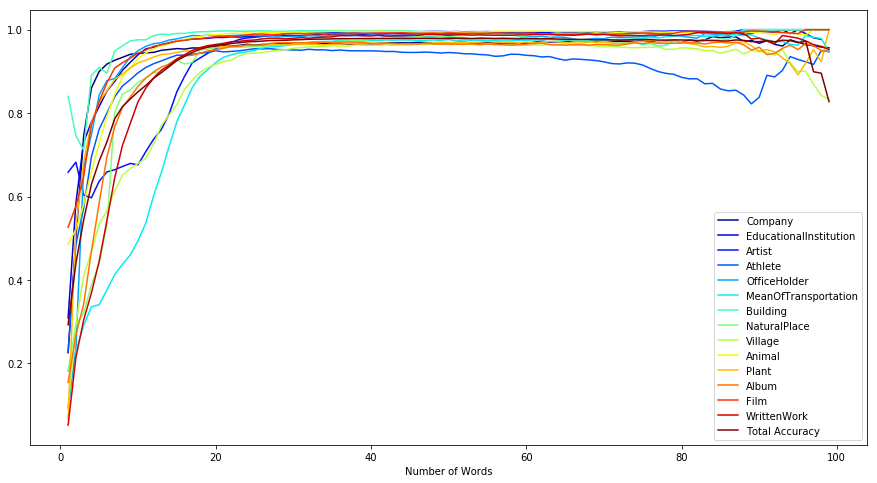

In [4]:
accuracies.plot(x ='Number of Words', figsize = (15,8), colormap = 'jet')
plt.show()

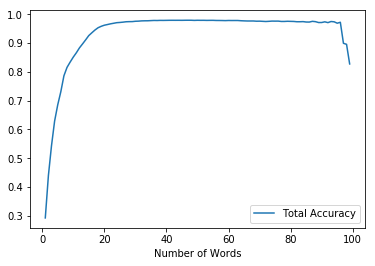

In [5]:
accuracies.plot(x = 'Number of Words', y = 'Total Accuracy')
plt.show()